In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


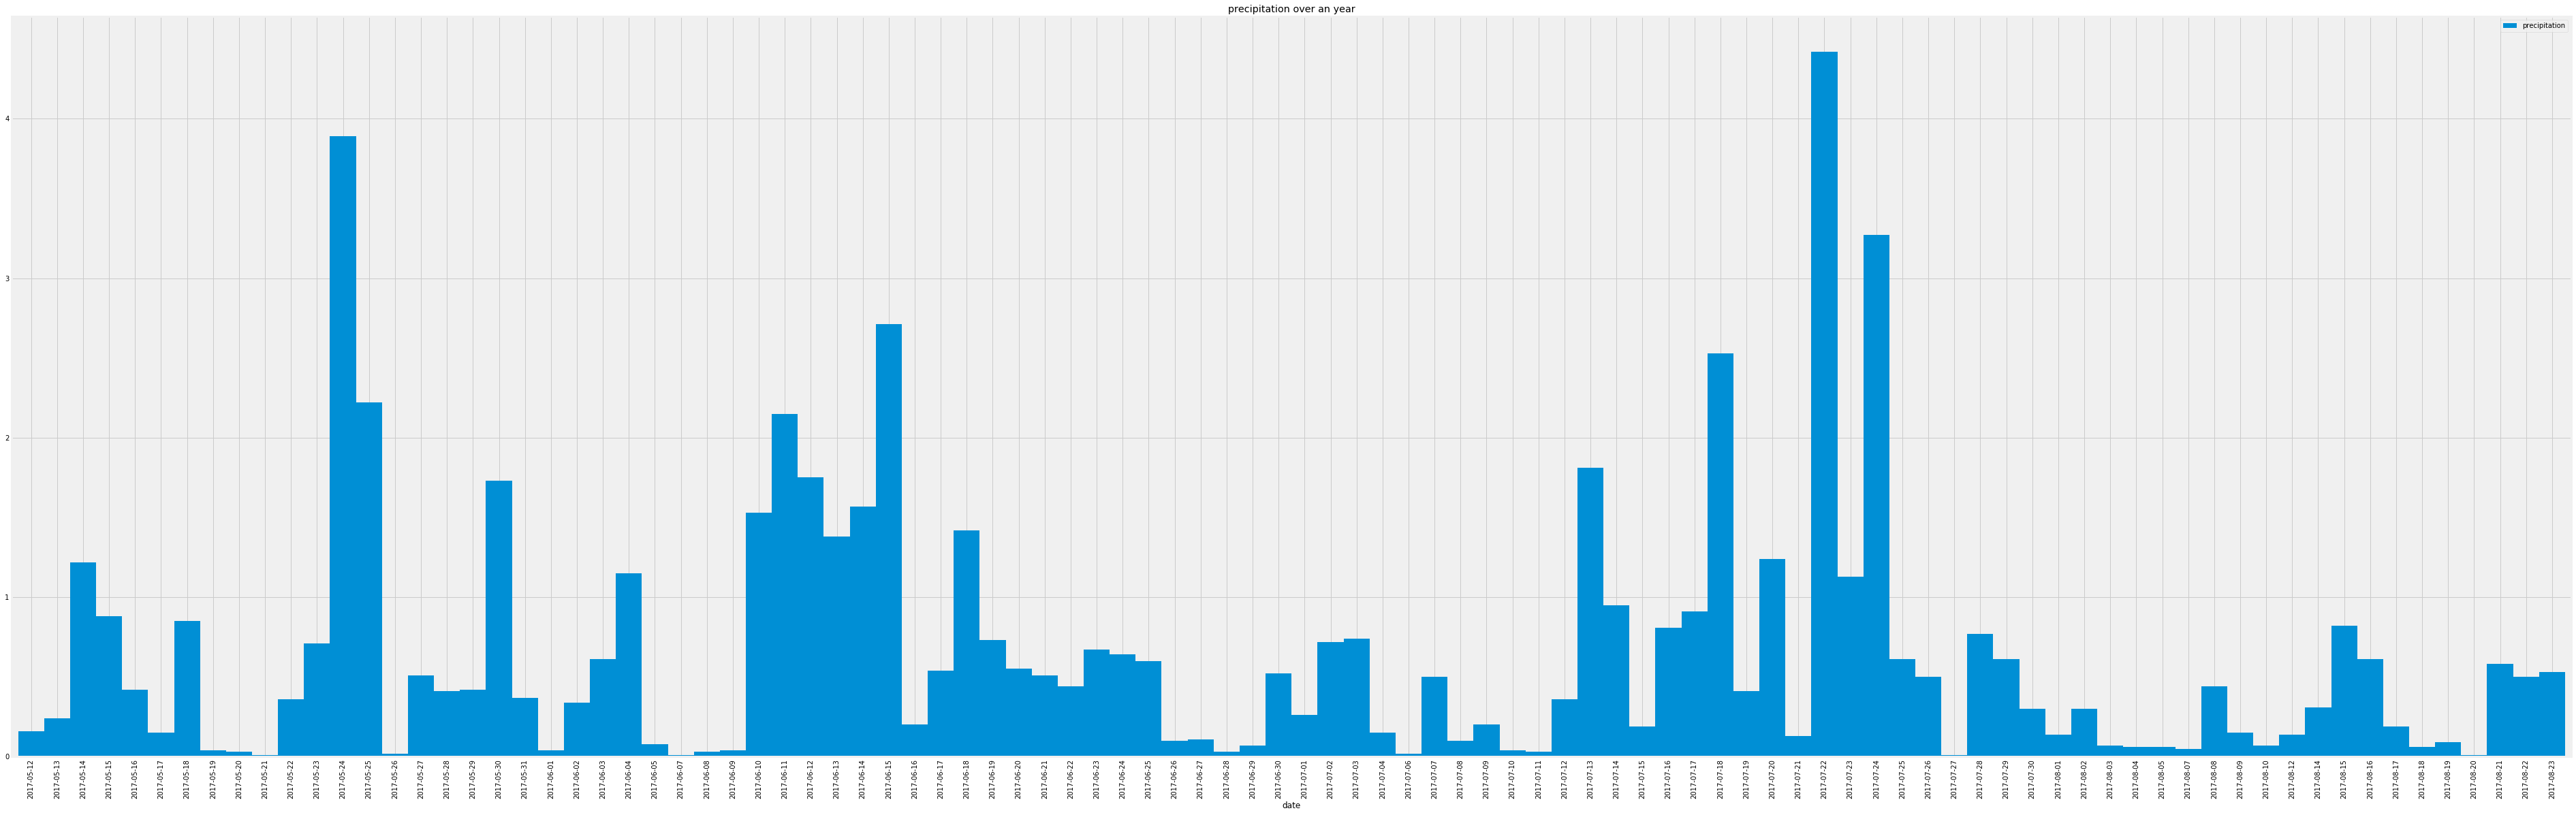

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    
# Calculate the date 1 year ago from the last data point in the database
last_to_last_yr = dt.date.today() - dt.timedelta(days=2*365)

# Perform a query to retrieve the data and precipitation scores
result = session.query(Measurement.date, func.sum(Measurement.prcp)).filter(Measurement.date>last_to_last_yr).\
                group_by(Measurement.date).order_by(Measurement.date).all()
    
# Save the query results as a Pandas DataFrame and set the index to the date column
result_df = pd.DataFrame(result[:],columns=['date','precipitation'])

result_df = result_df.dropna().set_index('date')
result_df = result_df.loc[result_df["precipitation"]>0,:]
result_df
# Sort the dataframe by date
result_df = result_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
result_df.plot(kind='bar', figsize=(60,20), title="precipitation over an year", width=1.0)
plt.savefig("precipitations.png")


![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
ult2 = session.query(Measurement.date, func.sum(Measurement.prcp)).filter(Measurement.date>last_to_last_yr).\
                group_by(Measurement.date).order_by(Measurement.date).all()

result_df2 = pd.DataFrame(result[:],columns=['date','precipitation'])

result_df2["precipitation"].describe()

count    104.000000
mean       0.615962
std        0.812341
min        0.000000
25%        0.070000
50%        0.390000
75%        0.732500
max        4.420000
Name: precipitation, dtype: float64

![describe](Images/describe.png)

In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(func.distinct(Measurement.station))).all()
station_count

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Count = func.count(Measurement.tobs).label("Count")
station_list = session.query(Measurement.station, func.count(Measurement.tobs).label("Count")).\
group_by(Measurement.station).order_by(Count.desc())

for sl in station_list:
    print(f"Station:{sl[0]}\tCount:{sl[1]}")

Station:USC00519281	Count:2772
Station:USC00519397	Count:2724
Station:USC00513117	Count:2709
Station:USC00519523	Count:2669
Station:USC00516128	Count:2612
Station:USC00514830	Count:2202
Station:USC00511918	Count:1979
Station:USC00517948	Count:1372
Station:USC00518838	Count:511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp_data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281")
print(temp_data[0])

(54.0, 85.0, 71.66378066378067)


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>last_to_last_yr).\
                filter(Measurement.station == "USC00519281")
result_temp_df = pd.DataFrame(result_temp[:],columns=['Date','TempObs'])
result_temp_df.head()

,Date,TempObs
0,2017-05-12,75.0
1,2017-05-13,76.0
2,2017-05-14,77.0
3,2017-05-15,74.0
4,2017-05-16,74.0


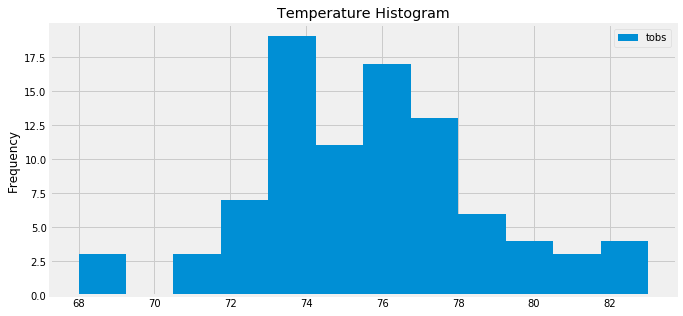

In [21]:
plt.figure(figsize=(10,5))
plt.hist(result_temp_df["TempObs"], bins=12, label='tobs')
plt.ylabel("Frequency")
plt.title("Temperature Histogram")
plt.legend()
plt.savefig("Temperature_Histogram.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2012-02-28','2012-03-05')
print(trip_temp)

[(62.0, 69.57142857142857, 74.0)]


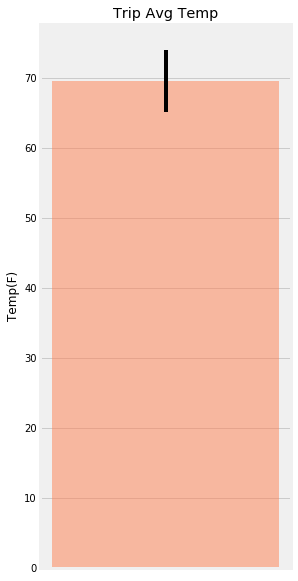

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,10))
plt.bar(1, trip_temp[0][1], color='coral', alpha=0.5, yerr=trip_temp[0][2]-trip_temp[0][1])
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylabel("Temp(F)")
plt.savefig("Trig_Avg_Temp_ErrBar.png")

In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Rainfall = func.avg(Measurement.prcp).label("Rainfall")
ly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation, \
                            func.avg(Measurement.prcp).label("Rainfall")).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= '2011-02-28').\
                filter(Measurement.date <= '2011-03-05').group_by(Measurement.station).order_by(Rainfall.desc())


index = 0
for rf in ly_rainfall:
    print(ly_rainfall[index])
    index = index + 1

('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.5825)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.392)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.37166666666666665)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.365)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.24166666666666667)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22999999999999998)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.126)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
